Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import time
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from causallib.estimation import IPW, MarginalOutcomeEstimator

import seaborn as sns
import seaborn.objects as so

from analysis_script import *
from bicause_tree import BICauseTree, crump

### Get data

In [3]:
data, x, t, y = get_data("natural_exp")

In [4]:
def augment_to_high_dim_data(X, d, seed=0):
    d_2_gen = d - X.shape[1]
    rng = np.random.default_rng(seed)
    extra_data = rng.normal(size=(X.shape[0], d_2_gen))
    extra_data = pd.DataFrame(
        extra_data, 
        index=X.index, 
        columns=[f"u{i}" for i in range(d_2_gen)]
    )
    res = X.join(extra_data)
    return res

Model and hyperparameters configuration

In [17]:
dataset = 'natural_exp'
file_name =None
run_multiprocessing = False

data, x, t, y = get_data(dataset)
test_size = 0.5
multiple_hypothesis_test_method = 'holm'
positivity_filtering_method = crump
positivity_filtering_kwargs = {}

models_to_compare = {
    "BICauseTree(Marginal)": BICauseTree(min_treat_group_size=2, asmd_threshold_split=0.1, max_depth=10,
                                         individual=False,
                                         multiple_hypothesis_test_alpha=0.05,
                                         multiple_hypothesis_test_method=multiple_hypothesis_test_method,
                                         positivity_filtering_method=positivity_filtering_method,
                                         positivity_filtering_kwargs=positivity_filtering_kwargs,
                                         outcome_model=MarginalOutcomeEstimator(learner=None)
                                         ),
    "Ground truth": (data['y1'], data['y0']),
}

outcome_names = ['BICauseTree(Marginal)']
tree_names = ['BICauseTree(Marginal)']
pscore_names = ['BICauseTree(Marginal)']
tree_filter_name = ['BICauseTree(Marginal)']

# Note: Causal Tree and Causal Forest are not implemented here as their API differs
# You may generate a nested list of ATE for the different bootstraps using the econml package
# with the following code for the models:
# from econml.dml import CausalForestDML
# 'Causal Tree': dml.CausalForestDML(n_estimators=50, inference=False)
# 'Causal Forest': dml.CausalForestDML(n_estimators=1, subforest_size=1, inference=False)


Model fitting

In [6]:
def model_fitting(models, X, t, y):
    effects, fitted_models, bootstrap_matrix = bootstrap_fit_effect(
        models, 
        X, t, y, 
        tree_names,
        n_bootstraps=n_bootstraps, 
        test_size=test_size, 
        run_multiprocessing=run_multiprocessing
    )
    return effects, fitted_models, bootstrap_matrix

def positivity_filtering(X, fitted_models, bootstrap_matrix):

    filtering_tree_models = {id: model for id, model in fitted_models.items() 
                             if id[0]  == 'BICauseTree(Marginal)'}
    
    if positivity_filtering_method is not None:
        positivity_matrix = generate_violating_matrix(filtering_tree_models, X)
    else:
        positivity_matrix = pd.DataFrame(data=np.ones((len(X), len(filtering_tree_models))), index=X.index)
    # positivity_matrix has non violating samples as 1 rest 0
    
    positivity_boot_mask = np.multiply(bootstrap_matrix, positivity_matrix)
    # positivity_boot_mask hqs test & non violating samples marked as 1 rest 0
    return positivity_matrix, positivity_boot_mask


In [25]:
# n_bootstraps = 1
n_bootstraps = 10
# n_bootstraps = 50

In [27]:
filtered_effect_bias_data = []
for d in [x.shape[1], 10, 25, 50, 75, 100, 200]:
    print(d, end="\t")
    start = time.time()
    
    Xd = augment_to_high_dim_data(x, d)
    effects, fitted_models, bootstrap_matrix = model_fitting(
        models_to_compare,
        Xd, t, y
    )
    positivity_matrix, positivity_boot_mask = positivity_filtering(
        Xd, fitted_models, bootstrap_matrix
    )

    filtered_effects = compute_filtered_effect(
        Xd, t, y, 
        bootstrap_matrix, positivity_matrix, 
        fitted_models, models_to_compare,
    )
    
    filtered_effect_diff_data = box_plot_effect_difference_data(
        models_to_compare, filtered_effects
    )
    filtered_effect_diff_data["n_covariates"] = d

    end = time.time()
    elapsed_time = (end - start) / 60
    filtered_effect_diff_data["elapsed_time"] = elapsed_time
    
    print(f"{elapsed_time:.3f}")
    filtered_effect_bias_data.append(filtered_effect_diff_data)
    
filtered_effect_bias_data = pd.concat(filtered_effect_bias_data, ignore_index=True)

2	1.148
10	1.460
25	4.625
50	6.105
75	6.295
100	7.774
200	9.374


In [28]:
fig_dir = Path("figures")
filtered_effect_bias_data.to_csv(fig_dir / f"high_dimensional_bias_boots={n_bootstraps}.csv")
filtered_effect_bias_data

,Phase,Model,Estimated ATE,n_covariates,elapsed_time
0,Test,BICauseTree(Marginal),0.005995,2,1.148484
1,Train,BICauseTree(Marginal),0.019834,2,1.148484
2,Test,BICauseTree(Marginal),0.012564,2,1.148484
3,Train,BICauseTree(Marginal),0.011379,2,1.148484
4,Test,BICauseTree(Marginal),0.005079,2,1.148484
...,...,...,...,...,...
135,Train,BICauseTree(Marginal),0.002245,200,9.373784
136,Test,BICauseTree(Marginal),0.018440,200,9.373784
137,Train,BICauseTree(Marginal),0.008082,200,9.373784
138,Test,BICauseTree(Marginal),0.016668,200,9.373784


C:\Users\204048756\Miniconda3\envs\bicause_trees\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


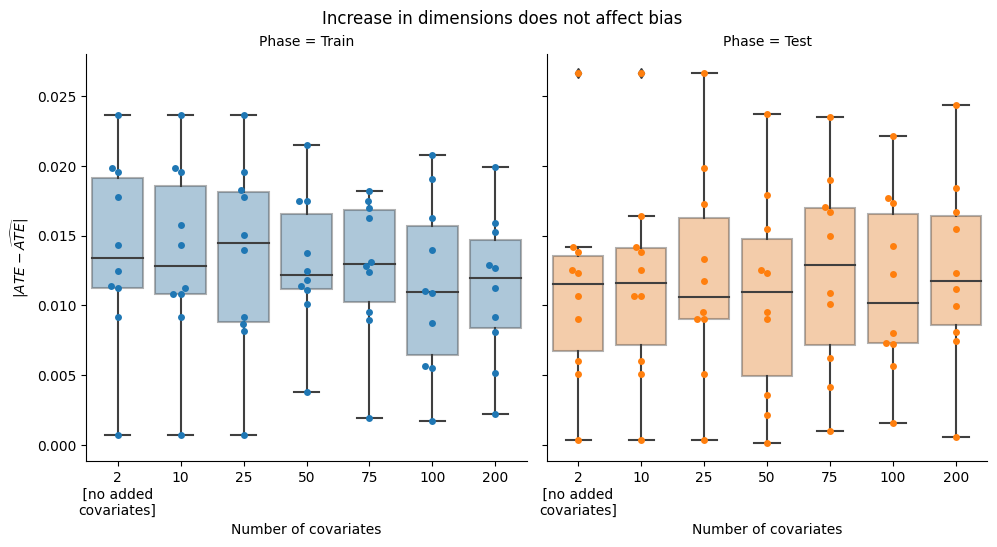

In [60]:
g = sns.catplot(
    data=filtered_effect_bias_data, 
    x="n_covariates", 
    y="Estimated ATE", 
    hue="Phase",
    col="Phase",
    hue_order=["Train", "Test"],
    col_order=["Train", "Test"],
    dodge=False,
    kind="box",
    boxprops=dict(alpha=.4),
    # color="grey",
)
sns.swarmplot(
    data=filtered_effect_bias_data.loc[filtered_effect_bias_data["Phase"] == "Train"], 
    x="n_covariates", 
    y="Estimated ATE",  
    color="C0", 
    dodge=False,
    legend=False,
    ax=g.fig.axes[0],
)
sns.swarmplot(
    data=filtered_effect_bias_data.loc[filtered_effect_bias_data["Phase"] == "Test"], 
    x="n_covariates", 
    y="Estimated ATE",  
    color="C1", 
    dodge=False,
    legend=False,
    ax=g.fig.axes[1],
)

xtickslabels = [s.get_text() for s in g.fig.axes[0].get_xticklabels()]
xtickslabels[0] = f"{xtickslabels[0]}\n [no added \ncovariates]"
g.set_xticklabels(xtickslabels)
g.set_ylabels(r"$ \vert ATE - \widehat{ATE} \vert $")
g.set_xlabels("Number of covariates")
g.fig.suptitle(
    "Increase in dimensions does not affect bias",
    y=1.02,
);

In [61]:
fig_dir = Path("figures")
for ext in ["svg", "png", "pdf"]:
    g.savefig(fig_dir / f"high_dimensional_bias_boots={n_bootstraps}.{ext}")

C:\Users\204048756\Miniconda3\envs\bicause_trees\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


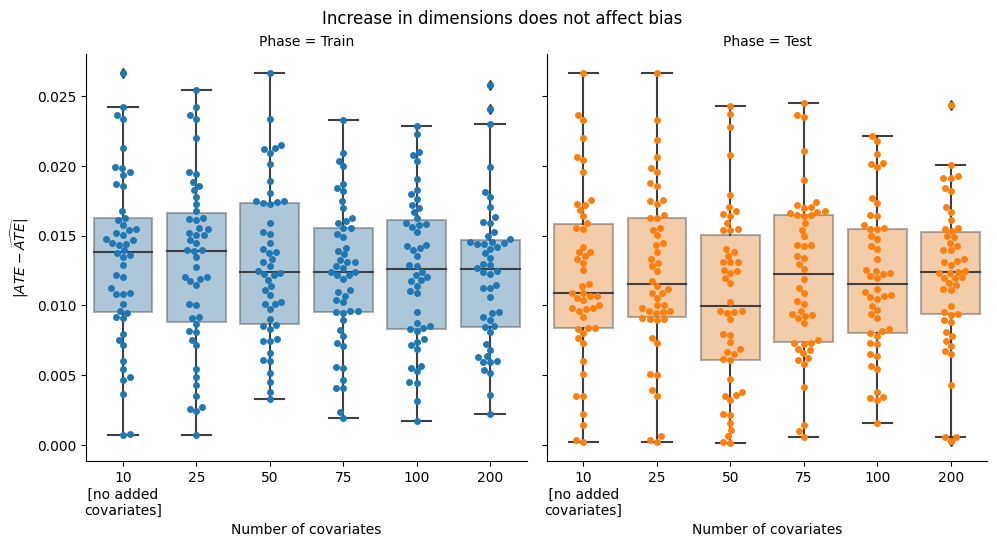

In [62]:
fig_dir = Path("figures")
n_bootstraps = 50
plot_data = pd.read_csv(fig_dir / f"high_dimensional_bias_boots={n_bootstraps}.csv")

g = sns.catplot(
    data=plot_data, 
    x="n_covariates", 
    y="Estimated ATE", 
    hue="Phase",
    col="Phase",
    hue_order=["Train", "Test"],
    col_order=["Train", "Test"],
    dodge=False,
    kind="box",
    boxprops=dict(alpha=.4),
    # color="grey",
)
sns.swarmplot(
    data=plot_data.loc[plot_data["Phase"] == "Train"], 
    x="n_covariates", 
    y="Estimated ATE",  
    color="C0", 
    dodge=False,
    legend=False,
    ax=g.fig.axes[0],
)
sns.swarmplot(
    data=plot_data.loc[plot_data["Phase"] == "Test"], 
    x="n_covariates", 
    y="Estimated ATE",  
    color="C1", 
    dodge=False,
    legend=False,
    ax=g.fig.axes[1],
)

xtickslabels = [s.get_text() for s in g.fig.axes[0].get_xticklabels()]
xtickslabels[0] = f"{xtickslabels[0]}\n [no added \ncovariates]"
g.set_xticklabels(xtickslabels)
g.set_ylabels(r"$ \vert ATE - \widehat{ATE} \vert $")
g.set_xlabels("Number of covariates")
g.fig.suptitle(
    "Increase in dimensions does not affect bias",
    y=1.02,
);

In [63]:
for ext in ["svg", "png", "pdf"]:
    g.savefig(fig_dir / f"high_dimensional_bias_boots={n_bootstraps}.{ext}")

Plot tree on entire dataset

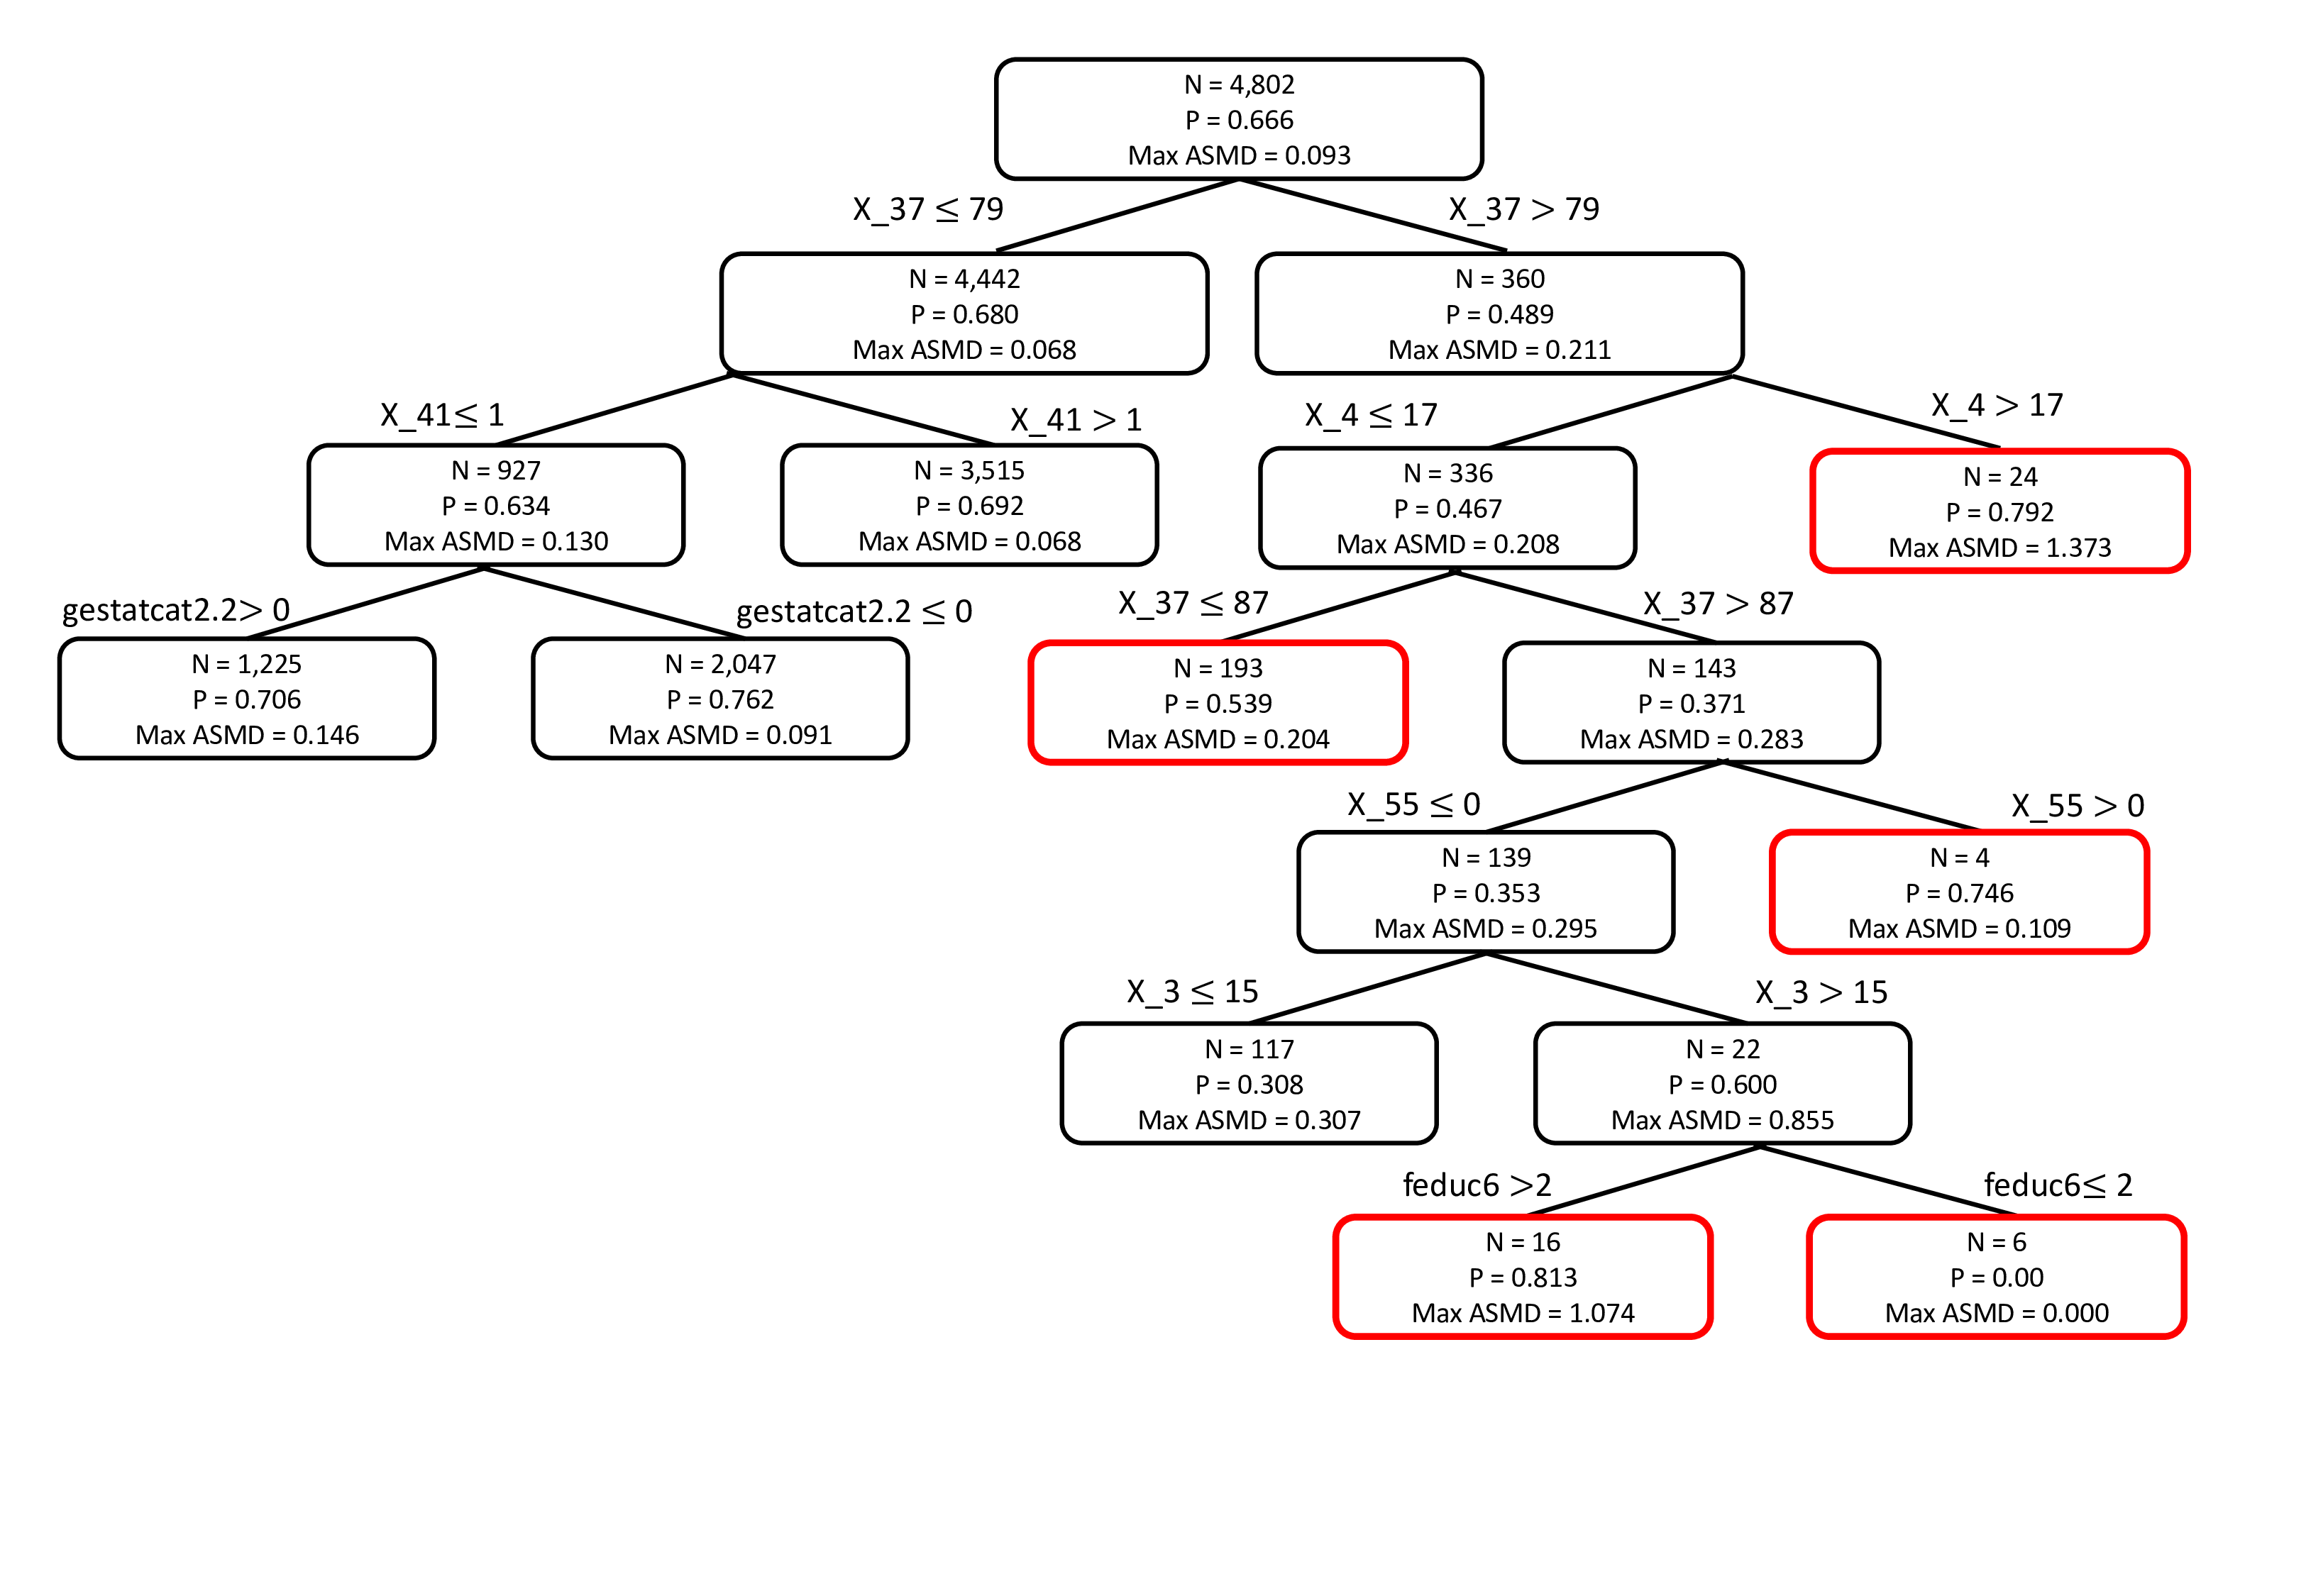

In [11]:
entire_fitted_model = {"BICauseTree(Marginal)": BICauseTree(min_treat_group_size=2, asmd_threshold_split=0.1, max_depth=10,
                                          individual=False,
                                          multiple_hypothesis_test_alpha=0.05,
                                          multiple_hypothesis_test_method=multiple_hypothesis_test_method,
                                          positivity_filtering_method=positivity_filtering_method,
                                          positivity_filtering_kwargs=positivity_filtering_kwargs,
                                          outcome_model=MarginalOutcomeEstimator(learner=None)
                                          )}
entire_fitted_model["BICauseTree(Marginal)"].fit(x, t, y)
save_tree_explains = save_tree_explains(x, t, entire_fitted_model, path=None)
